In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import math

In [2]:
# --- Load .mat file ---
mat = sio.loadmat("C_Elegans_Network_Data.mat")
mat1 = sio.loadmat("Worm279dir.mat")
W_ej = mat["Gap_Junction"]     # gap junction (undirected)
W_syn = mat["Synapse"]    # synapse (directed)
labels_raw = mat1["Worm279_labelled"]

# Extract neuron labels + classes
neuron_labels = [str(l[0]) for l in labels_raw[:, 0].flatten()]
neuron_classes = [str(l[0]) for l in labels_raw[:, 1].flatten()]

# Colors for classes
class_set = sorted(set(neuron_classes))
class_to_color = {cls: c for cls, c in zip(class_set, plt.cm.tab10.colors)}


In [3]:
# --- Load files ---
mat_file = "data/sbm_partition_I=5_combined_comm=6_2_new.mat"
#mat_file = "data/signalingCommunities.mat"

# Load group indices from .mat file
mat_data = sio.loadmat(mat_file)
group_indices = mat_data['groupIndices']

# Prepare an array of labels for 279 neurons (default -1 meaning "unassigned")
labels_from_mat = -1 * np.ones(279, dtype=int)

# Assign group labels
for group_id in range(group_indices.shape[0]):
    indices = group_indices[group_id, 0].flatten() - 1  # subtract 1 (MATLAB is 1-based)
    labels_from_mat[indices] = group_id  # group_id runs 0,1,...,5

labels_filtered = labels_from_mat

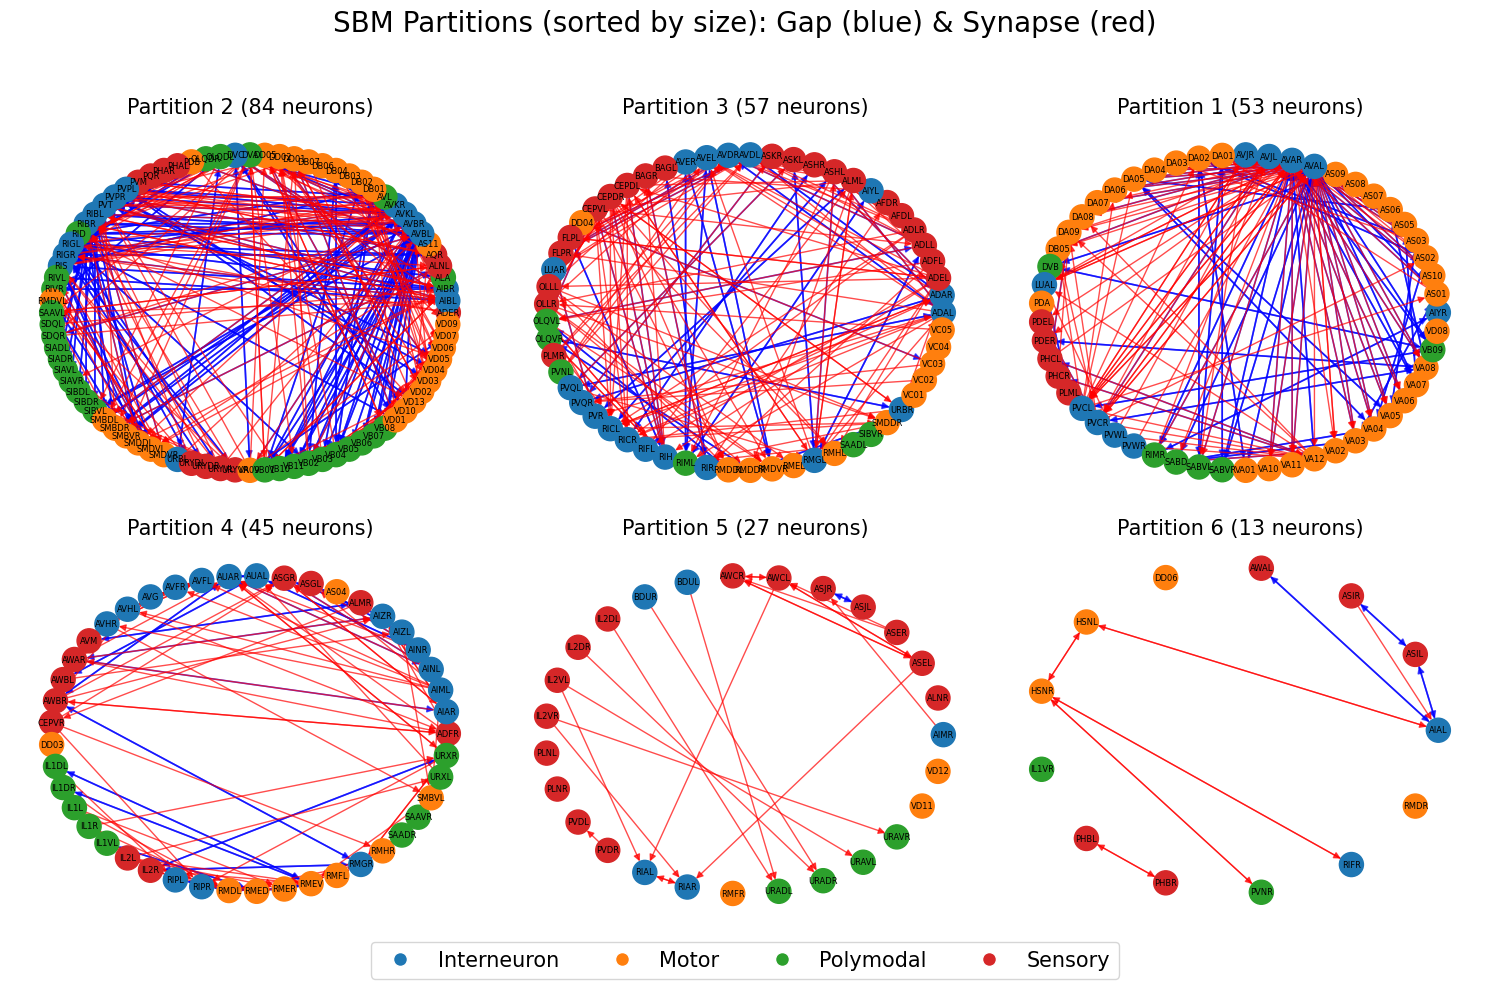

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def build_partition_graph(block_id, labels_filtered, W_ej, W_syn):
    nodes_in_block = np.where(labels_filtered == block_id)[0]
    if len(nodes_in_block) == 0:
        return None, None

    G = nx.DiGraph()
    for idx in nodes_in_block:
        G.add_node(idx, label=neuron_labels[idx],
                         cls=neuron_classes[idx],
                         color=class_to_color[neuron_classes[idx]])

    # Gap junction edges (undirected, add both directions)
    for i in nodes_in_block:
        for j in nodes_in_block:
            if i < j and W_ej[i, j] > 0:
                G.add_edge(i, j, weight=W_ej[i, j], etype="gap")
                G.add_edge(j, i, weight=W_ej[j, i], etype="gap")

    # Synapse edges (directed)
    for i in nodes_in_block:
        for j in nodes_in_block:
            if W_syn[i, j] > 0:
                G.add_edge(i, j, weight=W_syn[i, j], etype="syn")

    return G, nodes_in_block

# --- Build all partition graphs ---
partition_graphs = []
num_blocks = labels_filtered.max() + 1
for b in range(num_blocks):
    G, nodes = build_partition_graph(b, labels_filtered, W_ej, W_syn)
    if G is not None:
        partition_graphs.append((b, len(nodes), G, nodes))

# --- Sort partitions by size (largest first) ---
partition_graphs.sort(key=lambda x: x[1], reverse=True)

# --- Plot all partitions together ---
cols = 3   # number of columns in the grid
rows = math.ceil(len(partition_graphs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axes = axes.flatten()

for ax, (b, size, G, nodes_in_block) in zip(axes, partition_graphs):
    pos = nx.circular_layout(G)
    node_colors = [G.nodes[n]["color"] for n in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, ax=ax)
    nx.draw_networkx_labels(G, pos,
        labels={n: G.nodes[n]["label"] for n in G.nodes},
        font_size=6, ax=ax)

    # Edges
    gap_edges = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="gap"]
    syn_edges = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="syn"]

    nx.draw_networkx_edges(G, pos, edgelist=gap_edges,
                           edge_color="blue", width=1.2, alpha=0.7, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=syn_edges,
                           edge_color="red", arrows=True, width=1.0, alpha=0.7, ax=ax)

    ax.set_title(f"Partition {b+1} ({size} neurons)", fontsize=15)
    ax.axis("off")

# Turn off any unused subplots
for j in range(len(partition_graphs), len(axes)):
    axes[j].axis("off")

# Add global legend for neuron classes
handles = [plt.Line2D([0],[0], marker='o', color='w',
                      markerfacecolor=class_to_color[cls], markersize=10,
                      label=cls) for cls in class_set]
fig.legend(handles=handles, loc="lower center", ncol=len(class_set), fontsize=15)

plt.suptitle("SBM Partitions (sorted by size): Gap (blue) & Synapse (red)", fontsize=20)
plt.tight_layout(rect=[0,0.05,1,0.95])
#plt.savefig("figures/sbm_partition_I=5_combined_comm=6_2.pdf", dpi=300, bbox_inches="tight")
plt.show()


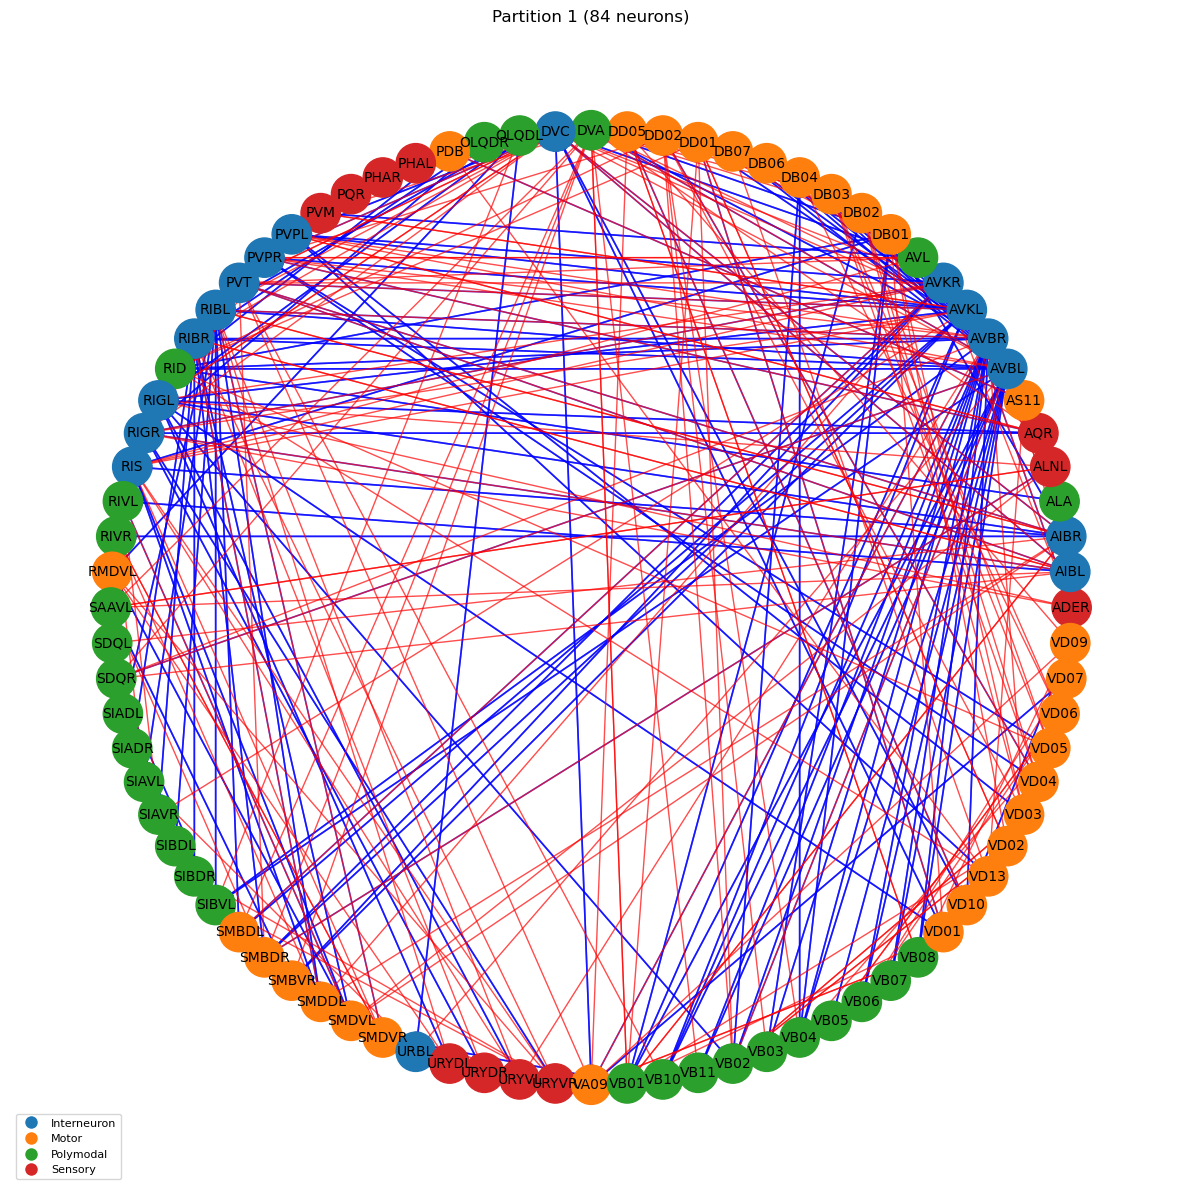

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Pick the partition index you want to see
b = 0   # <-- change this manually (0-based index in partition_graphs)

# Get graph for this block
_, size, G, nodes_in_block = partition_graphs[b]

plt.figure(figsize=(15,15))
pos = nx.circular_layout(G)
node_colors = [G.nodes[n]["color"] for n in G.nodes]

# Draw nodes + labels
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800)
nx.draw_networkx_labels(G, pos,
    labels={n: G.nodes[n]["label"] for n in G.nodes},
    font_size=10)

# Draw edges
gap_edges = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="gap"]
syn_edges = [(u,v) for u,v,d in G.edges(data=True) if d["etype"]=="syn"]

nx.draw_networkx_edges(G, pos, edgelist=gap_edges,
                       edge_color="blue", width=1.2, alpha=0.7)
nx.draw_networkx_edges(G, pos, edgelist=syn_edges,
                       edge_color="red", arrows=True, width=1.0, alpha=0.7)

plt.title(f"Partition {b+1} ({size} neurons)", fontsize=12)
plt.axis("off")

# Legend
handles = [plt.Line2D([0],[0], marker='o', color='w',
                      markerfacecolor=class_to_color[cls], markersize=10,
                      label=cls) for cls in class_set]
plt.legend(handles=handles, loc="lower left", fontsize=8)

#plt.savefig("figures/subcircuit3_mechanosensation_I=50000_comm=6.png", dpi=300, bbox_inches="tight")

plt.show()


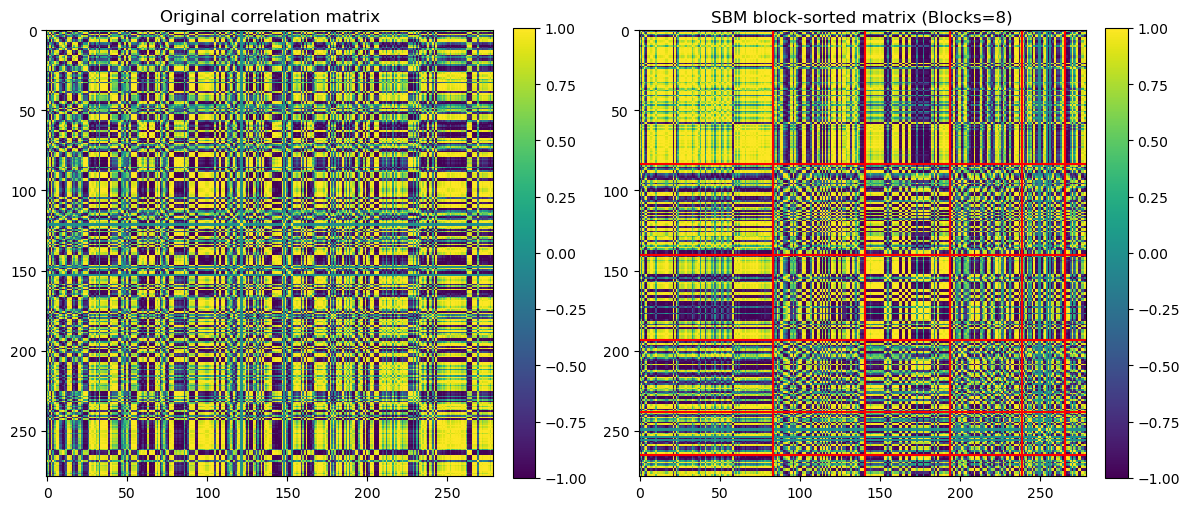

In [40]:
# Load .mat file
mat = sio.loadmat("data/pearson_correlation-matrix-for-I=50000-tr-weighted.mat")
corr_matrix = mat["v_pearson_corr_matrix"][:, :, 3]

# --- Load group assignments ---
mat_data = sio.loadmat("data/sbm_partition_I=5_combined_comm=6_3.mat")
group_indices = mat_data['groupIndices']

# Flatten the groups into a list of arrays
groups = [group_indices[i,0].flatten() - 1 for i in range(group_indices.shape[0])]  # MATLAB 1-based → Python 0-based

# Create ordering of neurons: concatenate all groups
ordering = np.concatenate(groups)

# Reorder the correlation matrix
corr_ordered = corr_matrix[np.ix_(ordering, ordering)]

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original
im0 = axes[0].imshow(corr_matrix, vmin=-1, vmax=1, interpolation="nearest")
axes[0].set_title(f"Original correlation matrix")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# SBM-sorted
im1 = axes[1].imshow(corr_ordered, vmin=-1, vmax=1, interpolation="nearest")
axes[1].set_title(f"SBM block-sorted matrix (Blocks=8)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Add red lines to separate groups
boundaries = np.cumsum([len(g) for g in groups])
for b in boundaries[:-1]:  # skip last since it's at 279
    plt.axhline(b-0.5, color="red", linewidth=1.5)
    plt.axvline(b-0.5, color="red", linewidth=1.5)

plt.tight_layout()
#plt.savefig("figures/corr_matrix-blocks_sbm_partition_I=50000_comm=8_#1.png", dpi=300, bbox_inches="tight")
plt.show()


# --- Plot ---
#plt.figure(figsize=(8,8))
#plt.imshow(corr_ordered, vmin=-1, vmax=1)
#plt.colorbar(label="Correlation")

# Add red lines to separate groups
#boundaries = np.cumsum([len(g) for g in groups])
#for b in boundaries[:-1]:  # skip last since it's at 279
#    plt.axhline(b-0.5, color="red", linewidth=1.5)
#    plt.axvline(b-0.5, color="red", linewidth=1.5)

#plt.title("Neuron correlation matrix grouped by SBM partition")
#plt.show()

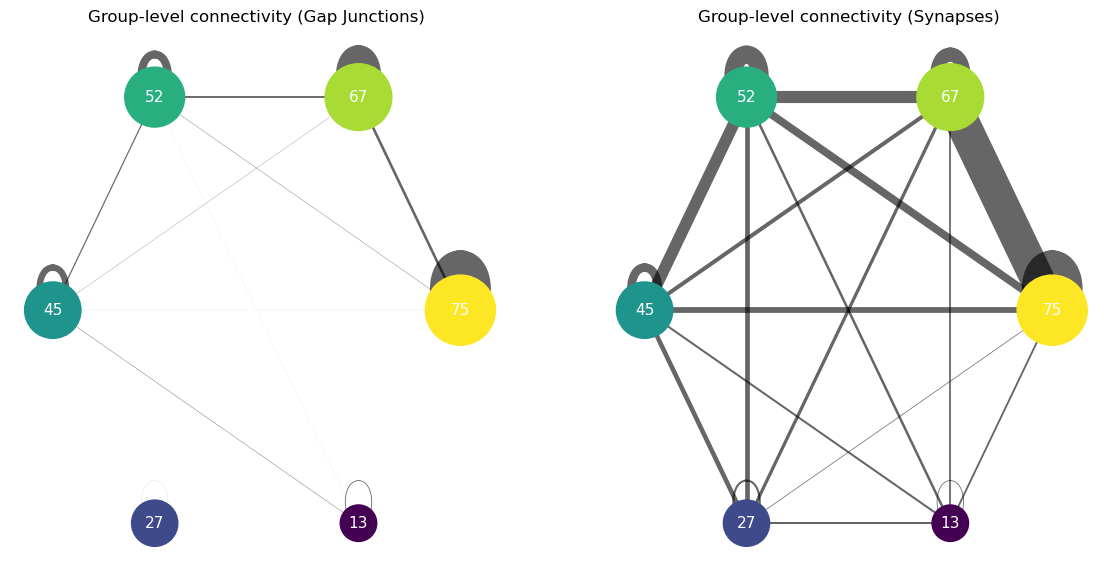

In [6]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import networkx as nx

# --- Load group info ---
mat_data = sio.loadmat("data/sbm_partition_I=5_combined_comm=6_3.mat")
group_indices = mat_data['groupIndices']
groups = [group_indices[i,0].flatten() - 1 for i in range(group_indices.shape[0])]  # MATLAB→Python

mat = sio.loadmat("C_Elegans_Network_Data.mat")
mat1 = sio.loadmat("Worm279dir.mat")
gap = mat["Gap_Junction"]     # gap junction (undirected)
syn = mat["Synapse"]    # synapse (directed)

# Combine them
adj = syn  

# --- Compute group-level connectivity ---
n_groups = len(groups)
group_sizes = [len(g) for g in groups]

def build_group_graph(adj):
    """Return group-level adjacency + intra-group sums as a NetworkX graph."""
    group_adj = np.zeros((n_groups, n_groups))
    intra_connections = []
    for i in range(n_groups):
        for j in range(n_groups):
            group_adj[i, j] = np.sum(adj[np.ix_(groups[i], groups[j])])
        intra_connections.append(group_adj[i, i])
    
    G = nx.Graph()
    for i in range(n_groups):
        G.add_node(i, size=group_sizes[i], intra=intra_connections[i])
    for i in range(n_groups):
        for j in range(i, n_groups):
            if group_adj[i, j] > 0:
                G.add_edge(i, j, weight=group_adj[i, j])
    return G

# Build graphs
G_gap = build_group_graph(gap)
G_syn = build_group_graph(syn)

# Layout (same for both so positions align)
pos = nx.circular_layout(G_gap)

# --- Custom circular layout: sort nodes by size ---
sorted_idx = np.argsort(group_sizes)[::-1]  # descending
theta = np.linspace(0, 2*np.pi, n_groups, endpoint=False)
pos = {node: (np.cos(theta[k]), np.sin(theta[k])) for k, node in enumerate(sorted_idx)}

# --- Map group sizes to colors (continuous colormap) ---
cmap = plt.cm.viridis
norm = plt.Normalize(min(group_sizes), max(group_sizes))
node_colors = [cmap(norm(G_gap.nodes[i]['size'])) for i in range(n_groups)]

# --- Draw function ---
def draw_group_graph(G, title, ax):
    sizes = [300 + 30*group_sizes[i] for i in range(n_groups)]
    nx.draw_networkx_nodes(G, pos, 
                           node_size=sizes, 
                           node_color=node_colors, ax=ax)
    weights = [G[u][v]['weight']/30 for u,v in G.edges()]  # scale factor
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6, ax=ax)
    labels = {i: str(group_sizes[i]) for i in range(n_groups)}
    #labels = {i: f"{group_sizes[i]}\n{int(G.nodes[i]['intra'])}" for i in range(n_groups)}
    nx.draw_networkx_labels(G, pos, labels, font_size=11, font_color="white", ax=ax)
    ax.set_title(title)
    ax.axis("off")

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14,7))
draw_group_graph(G_gap, "Group-level connectivity (Gap Junctions)", axes[0])
draw_group_graph(G_syn, "Group-level connectivity (Synapses)", axes[1])
#plt.savefig("figures/group_connectivity_sbm_partition_I=5_combined_comm=6_1.png", dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipykernel_255585/429602728.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(groups))


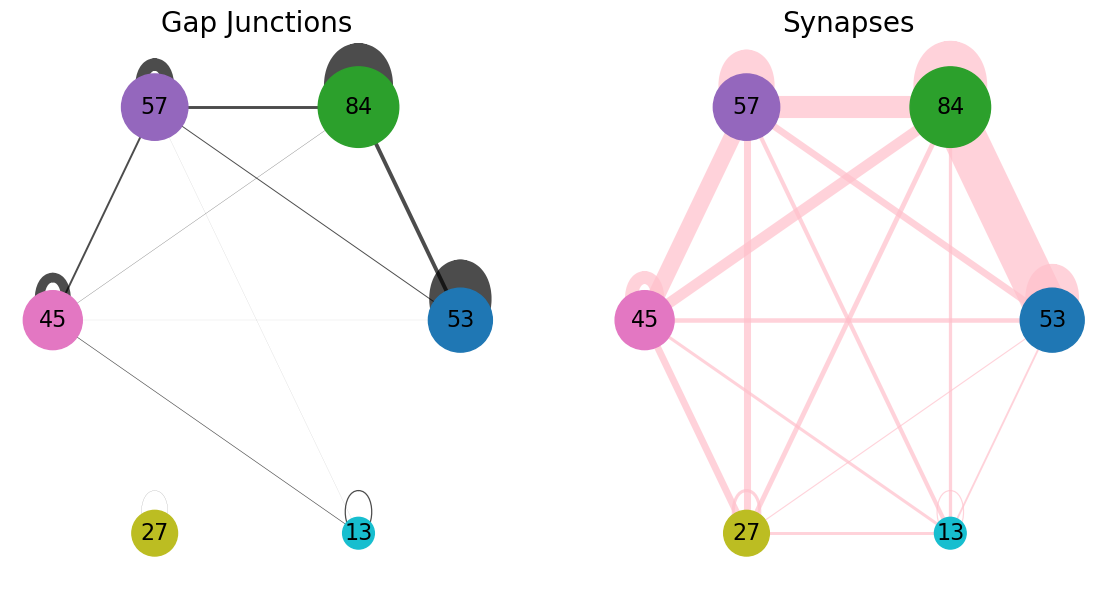

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.io as sio

# --- Load group info ---
mat_data = sio.loadmat("data/sbm_partition_I=5_combined_comm=6_2_new.mat")
#mat_data = sio.loadmat("data/signalingCommunities.mat")
group_indices = mat_data['groupIndices']
groups = [group_indices[i,0].flatten() - 1 for i in range(group_indices.shape[0])]  # MATLAB→Python

# Example adjacency matrices (replace with your files)
mat = sio.loadmat("C_Elegans_Network_Data.mat")
mat1 = sio.loadmat("Worm279dir.mat")
gap = mat["Gap_Junction"]     # gap junction (undirected)
syn = mat["Synapse"]    # synapse (directed)

# Function to compute group-level connectivity
def compute_group_graph(adj, groups):
    n_groups = len(groups)
    group_sizes = [len(g) for g in groups]
    group_adj = np.zeros((n_groups, n_groups))
    for i in range(n_groups):
        for j in range(n_groups):
            group_adj[i, j] = np.sum(adj[np.ix_(groups[i], groups[j])])
    return group_adj, group_sizes

# Compute group graphs
gap_group_adj, group_sizes = compute_group_graph(gap, groups)
syn_group_adj, _ = compute_group_graph(syn, groups)

# --- Sort groups by size ---
#sorted_idx = np.argsort(group_sizes)[::-1]  # descending
sorted_idx = np.arange(len(group_sizes))
group_sizes_sorted = [group_sizes[i] for i in sorted_idx]

# --- Assign colors serially from tab10 ---
cmap = plt.cm.get_cmap("tab10", len(groups))
colors = [cmap(i) for i in range(len(groups))]

# --- Build graph drawing function ---
def build_graph(adj, group_sizes, sorted_idx, colors, title, edgecolor):
    n_groups = len(group_sizes)
    G = nx.Graph()
    for rank, i in enumerate(sorted_idx):
        G.add_node(i, size=group_sizes[i], color=colors[rank])
    for i in range(n_groups):
        for j in range(i, n_groups):
            if adj[i, j] > 0:
                G.add_edge(i, j, weight=adj[i, j])
    pos = nx.circular_layout(G, scale=2.0)  # circular layout
    node_sizes = [1 + 40*group_sizes[i] for i in sorted_idx]
    node_colors = [colors[rank] for rank, i in enumerate(sorted_idx)]
    nx.draw_networkx_nodes(G, pos, nodelist=sorted_idx, node_size=node_sizes, node_color=node_colors)
    weights = [G[u][v]['weight']/20 for u,v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.7,edge_color = edgecolor)
    labels = {i: str(group_sizes[i]) for i in range(n_groups)}
    nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color="black")
    plt.title(title,  fontsize=20)
    plt.axis("off")


# --- Plot side by side ---
plt.figure(figsize=(14,7))
plt.subplot(121)
build_graph(gap_group_adj, group_sizes, sorted_idx, colors, "Gap Junctions","black")
plt.subplot(122)
build_graph(syn_group_adj, group_sizes, sorted_idx, colors, "Synapses", "pink")
#plt.savefig("figures/group_connectivity_sbm_partition_I=5_combined_comm=6_2_new.svg", dpi=600, bbox_inches="tight")
plt.show()
